In [42]:
import pandas as pd
df = pd.read_csv('played_out_cleaned.csv')

In [43]:
df.keys()

Index(['position', 'played_at', 'duration_ms', 'explicit', 'track_id',
       'track_name', 'popularity', 'first_genre', 'user', 'gender', 'age',
       'acousticness', 'danceability', 'energy', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'valence',
       'artist'],
      dtype='object')

In [44]:

df = df[['position', 'track_id', 'track_name', 'popularity', 'first_genre', 
         'user', 'acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'key', 'mode']]
df.head()

,position,track_id,track_name,popularity,first_genre,user,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key,mode
0,0,7p6oXzBSPAXXz8Xb8gBPki,Subzero - Original Mix,45,3,19befa2d20a544b3819a1236cf7536c4_Harsh1,0.58800,0.793,0.608,0.8610,0.0991,-11.638,0.0673,124.988,0.118,6.0,0.0
1,0,3ENHpbTuY72FukZbwGP6bc,Tear Away,67,4,24bebb12512f476a8e08b14a1aaa08ea_Hannah,0.00055,0.611,0.648,0.0028,0.0846,-4.579,0.0441,132.983,0.457,0.0,1.0
2,0,6nz35DNIzbtj5ztpDEcW1j,"Kick, Push",64,2,6016a0c171f34d44bc5840e0f521a034_D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,7p6oXzBSPAXXz8Xb8gBPki,Subzero - Original Mix,45,3,6f0f1e2e101f4f208ede37b241d6fc4c_31owtsxu6xlbj...,0.58800,0.793,0.608,0.8610,0.0991,-11.638,0.0673,124.988,0.118,6.0,0.0
4,0,1lK5iIMKifrxERzS3iimJH,Breathe on Me,56,1,f9a2b3c8d4e1f7a0b5c6d9e2f1a3b8c,0.00209,0.709,0.565,0.0125,0.0901,-6.395,0.0471,112.203,0.571,5.0,0.0


# Scale audio features

from sklearn.discriminant_analysis import StandardScaler
scaler = StandardScaler()  
features = ['popularity', 'acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
df[features] = scaler.fit_transform(df[features])

# Impute audio features with avg features from the first two songs of each genre
first_songs = df[df['position'] < 2][features + ['position', 'track_id', 'first_genre']].drop_duplicates().sort_values(['first_genre', 'position']).reset_index(drop=True)
imputation_values = first_songs.groupby('first_genre').agg({'acousticness':'mean',
                                                            'danceability':'mean',
                                                            'energy':'mean',
                                                            'instrumentalness':'mean',
                                                            'liveness':'mean',
                                                            'loudness':'mean',
                                                            'speechiness':'mean',
                                                            'tempo':'mean',
                                                            'valence':'mean'}).reset_index().set_index('first_genre')
imputation_values

In [45]:
# Imputation by Median since, since the marginal distribution is skewed groupwise

from sklearn.discriminant_analysis import StandardScaler
scaler = StandardScaler()  
features = ['popularity', 'acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
df[features] = scaler.fit_transform(df[features])

imputation_values = df.groupby('first_genre').agg({'popularity':'median',
                                                        'acousticness':'median',
                                                        'danceability':'median',
                                                        'energy':'median',
                                                        'instrumentalness':'median',
                                                        'liveness':'median',
                                                        'loudness':'median',
                                                        'speechiness':'median',
                                                        'tempo':'median',
                                                        'valence':'median'}).reset_index().set_index('first_genre')
imputation_values

,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
first_genre,,,,,,,,,,
1,0.760433,-0.510652,-0.076188,0.208565,-0.513115,-0.456908,0.375016,-0.526811,-0.162270,-0.042802
2,0.438647,-0.614055,0.793388,0.182447,-0.513179,-0.304894,0.432448,0.080797,-0.131009,0.236815
3,0.245576,-0.736483,0.454041,0.645098,-0.512969,-0.244088,0.470777,-0.328409,0.107526,-0.034697
4,0.567361,-0.830511,0.125299,0.786878,-0.513179,-0.282091,0.591547,-0.211382,-0.063636,0.402965
5,-0.719780,1.777988,-1.295715,-1.634576,2.019625,-0.475910,-1.248148,-0.488061,-0.054642,-0.857340


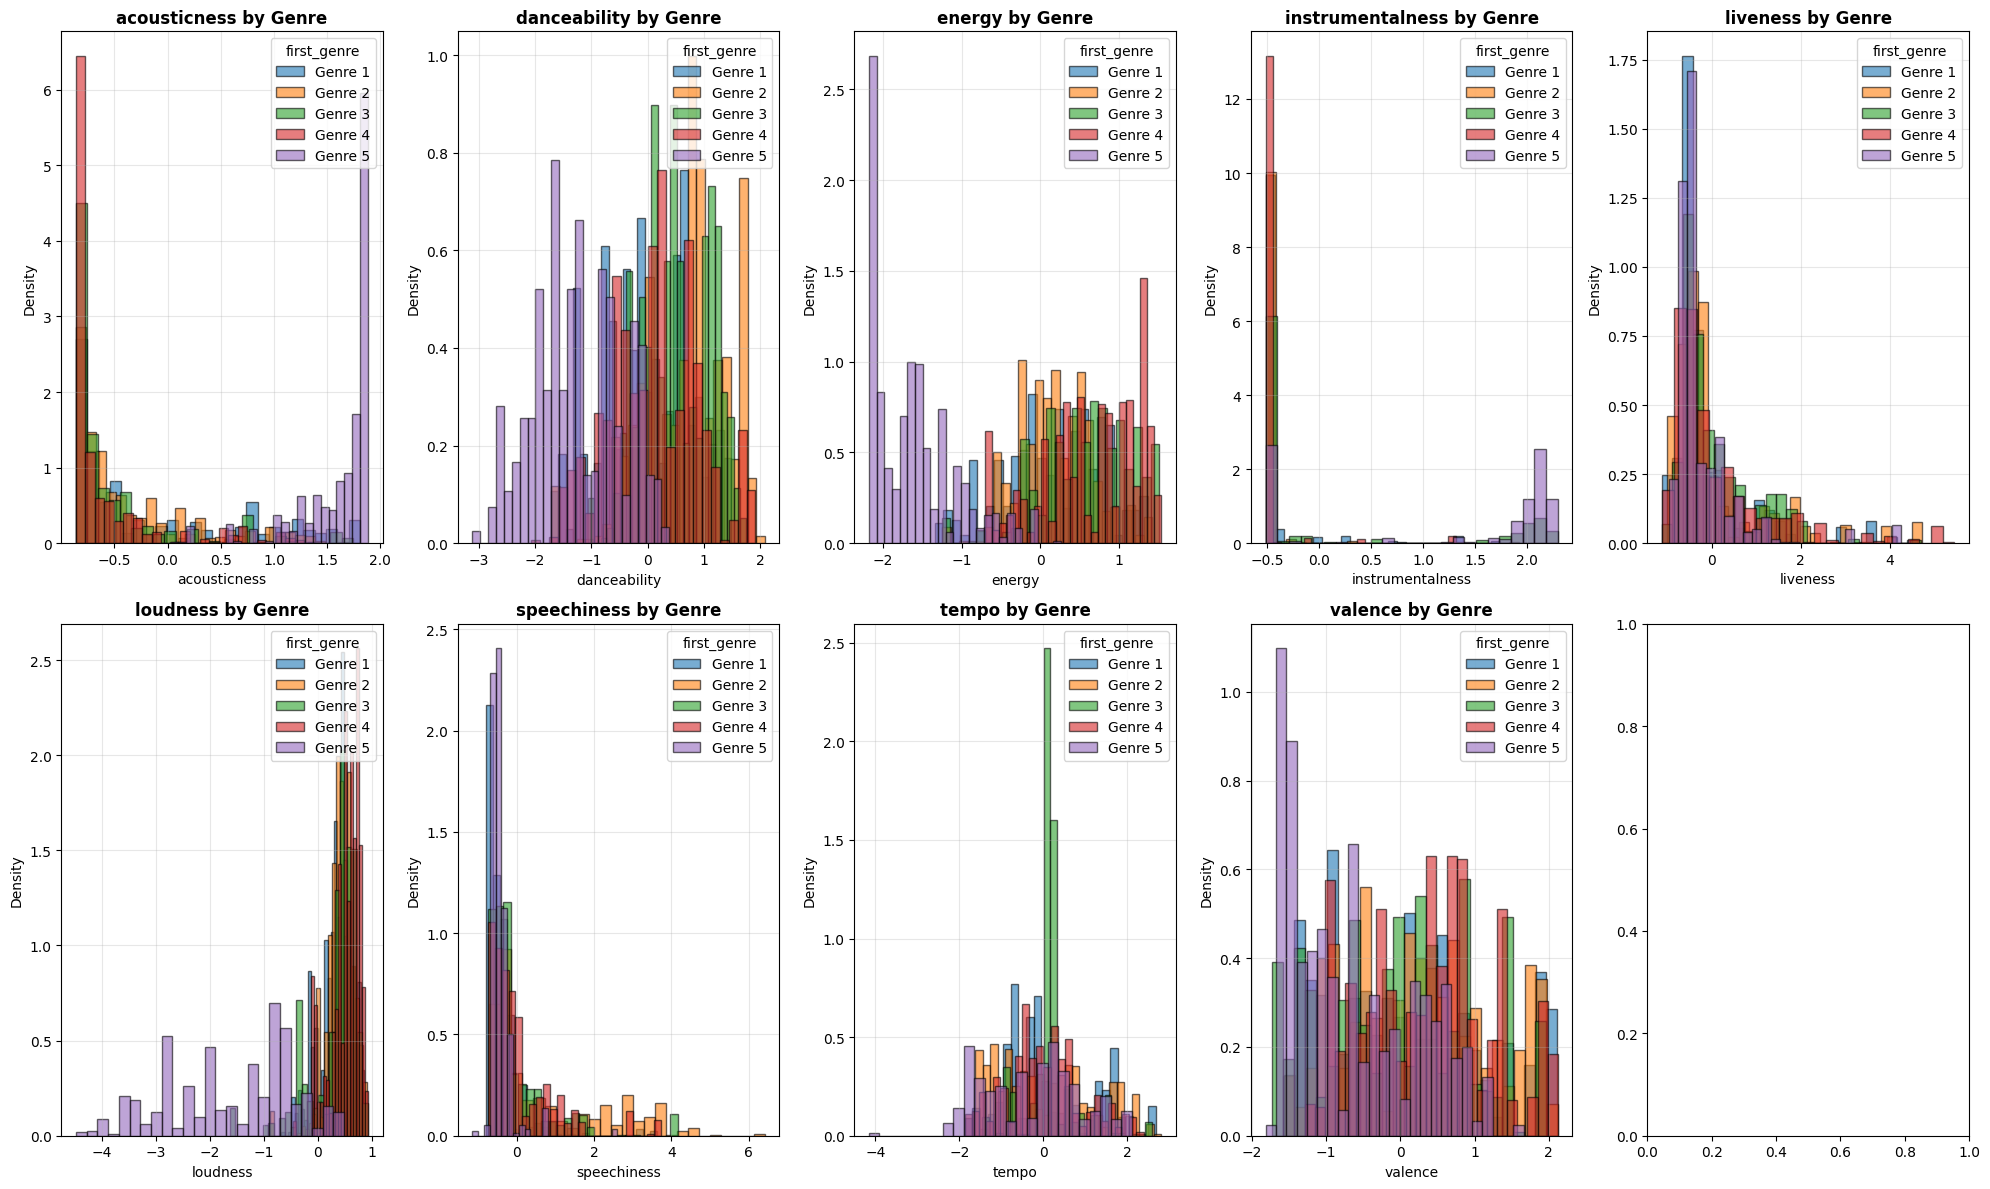

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming 'features' = continuous_features from before
continuous_features = [
    'acousticness', 'danceability', 'energy', 'instrumentalness',
    'liveness', 'loudness', 'speechiness', 'tempo', 'valence'
]

# 2 rows × 5 columns for 10 features
fig, axes = plt.subplots(2, 5, figsize=(20, 12))
axes = axes.flatten()

for idx, feature in enumerate(continuous_features):
    # Plot density by first_genre (5 genres)
    for genre in sorted(df['first_genre'].unique()):
        subset = df[df['first_genre'] == genre][feature].dropna()
        axes[idx].hist(subset, bins=25, alpha=0.6, density=True, 
                      label=f'Genre {genre}', edgecolor='black')
    
    axes[idx].set_title(f'{feature} by Genre', fontweight='bold')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Density')
    axes[idx].legend(title='first_genre', loc='upper right')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


<Figure size 2000x1200 with 0 Axes>

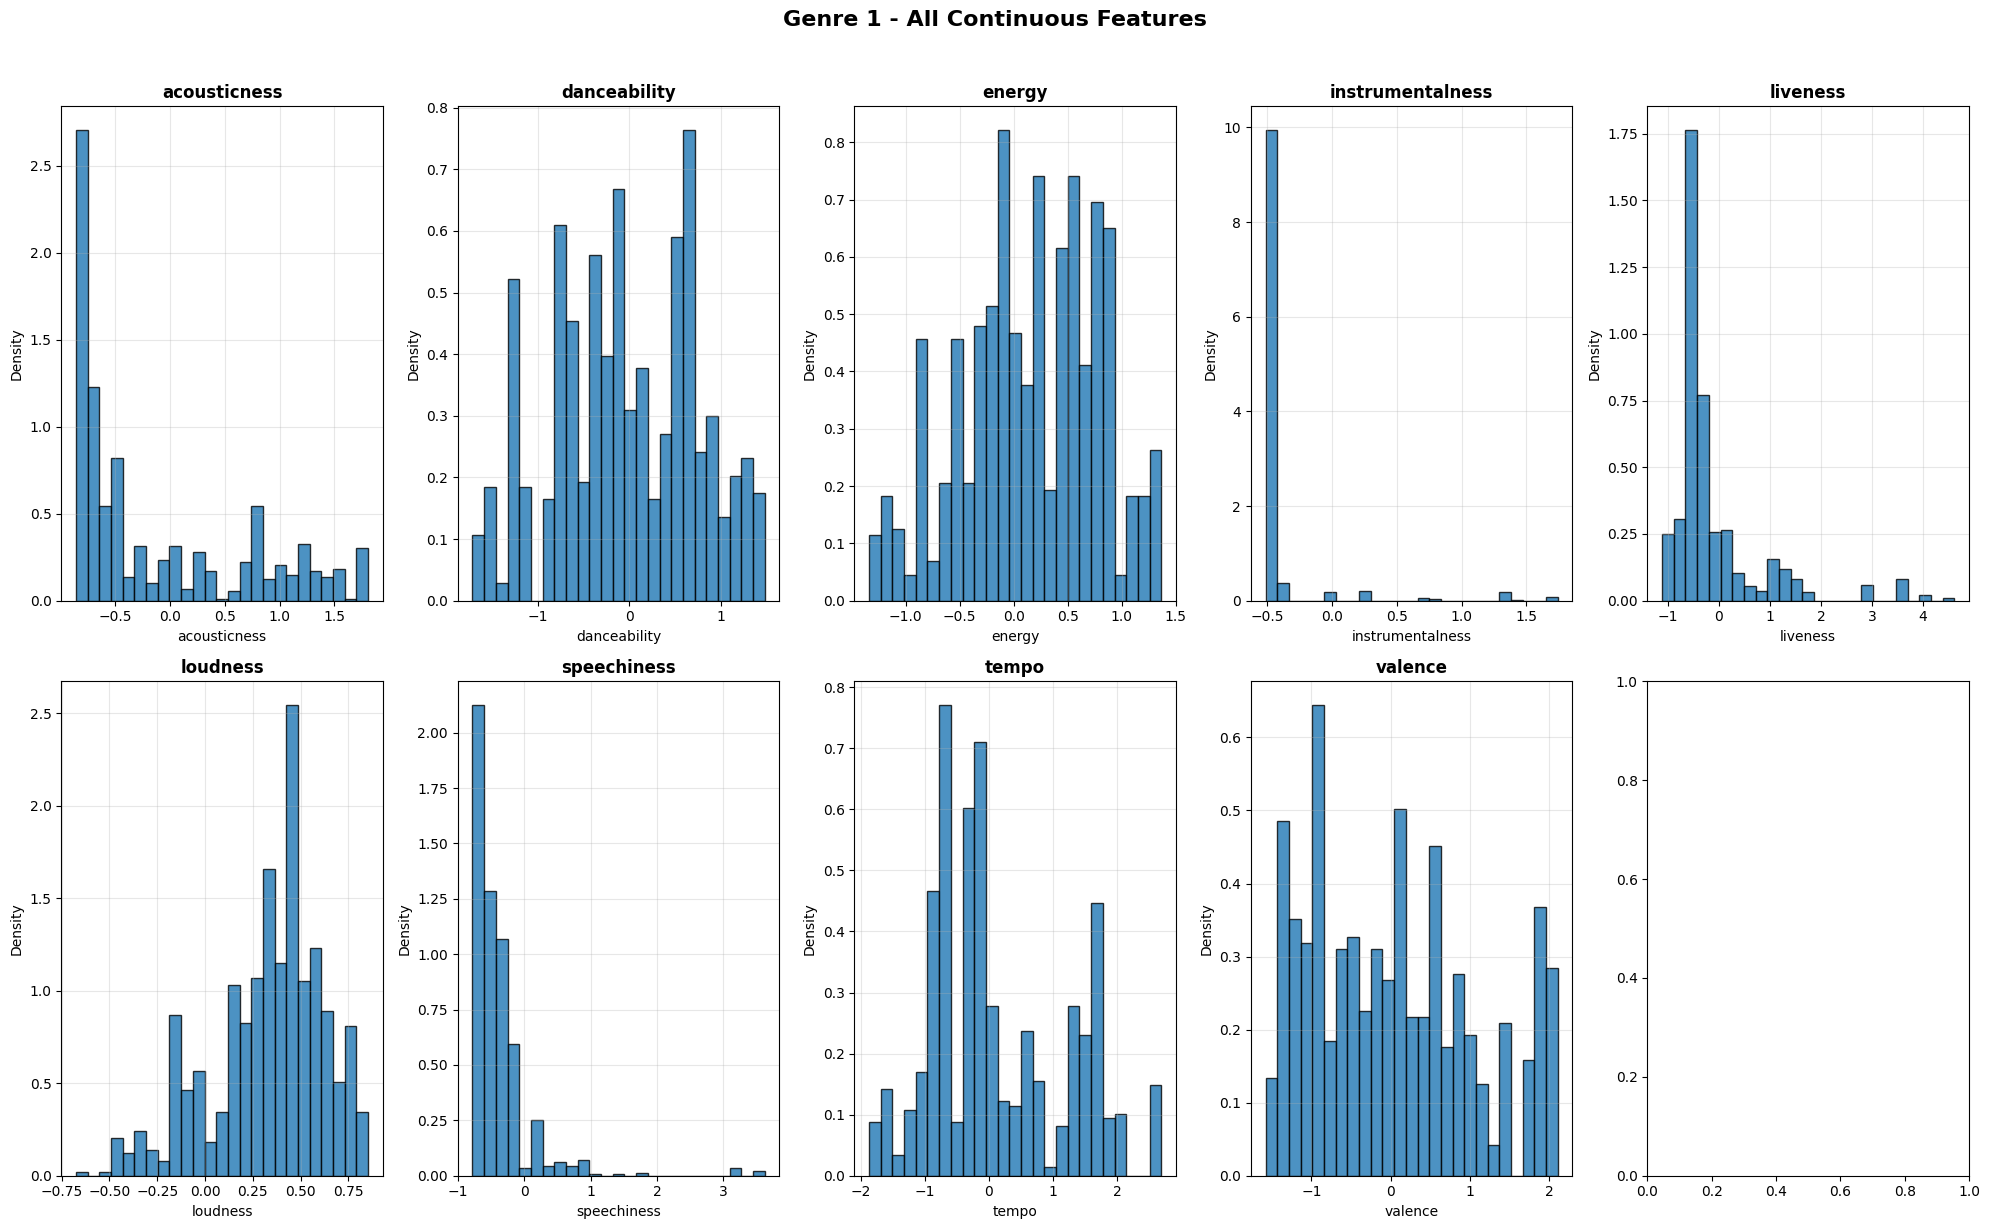

<Figure size 2000x1200 with 0 Axes>

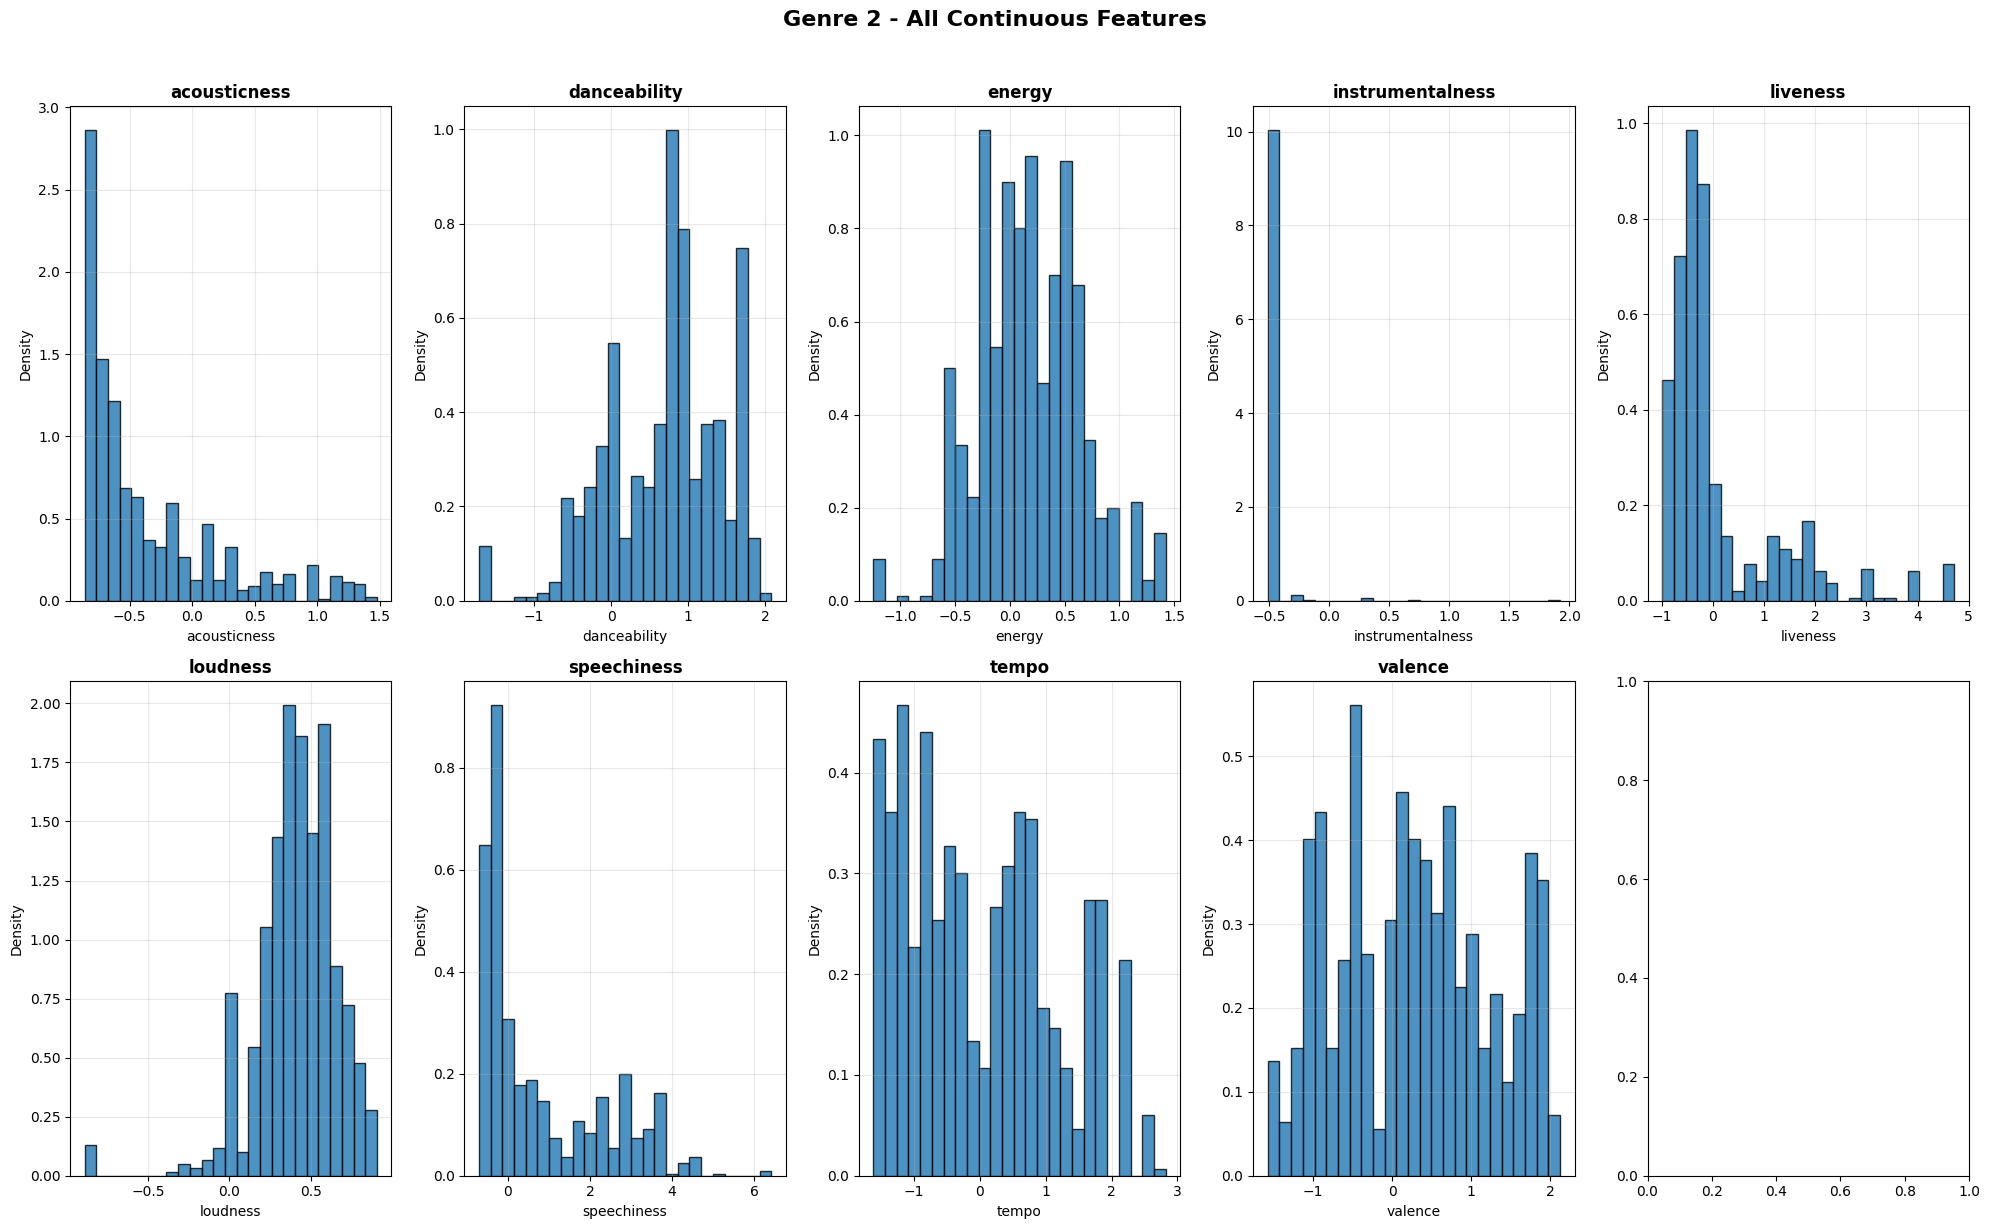

<Figure size 2000x1200 with 0 Axes>

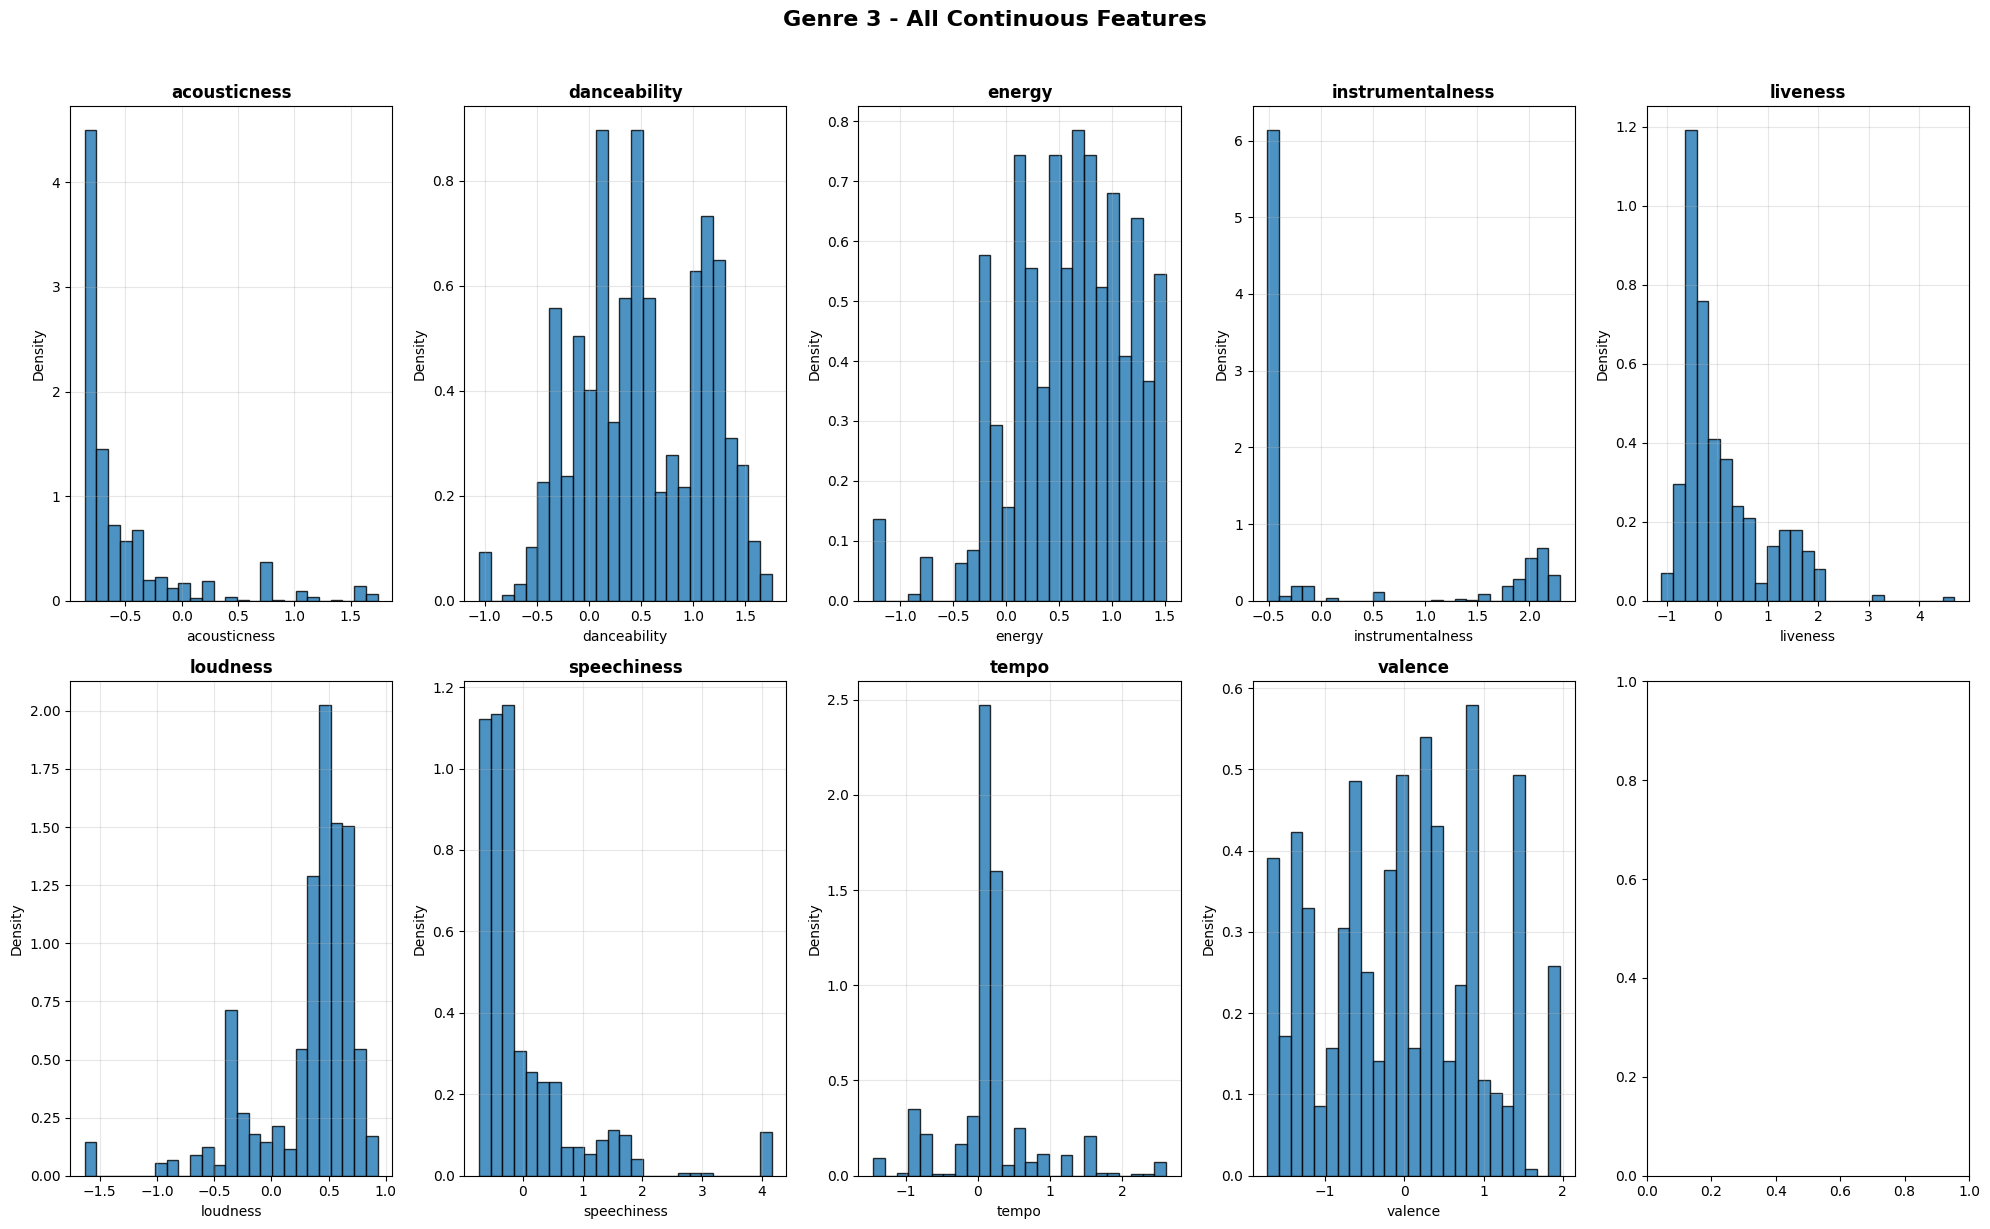

<Figure size 2000x1200 with 0 Axes>

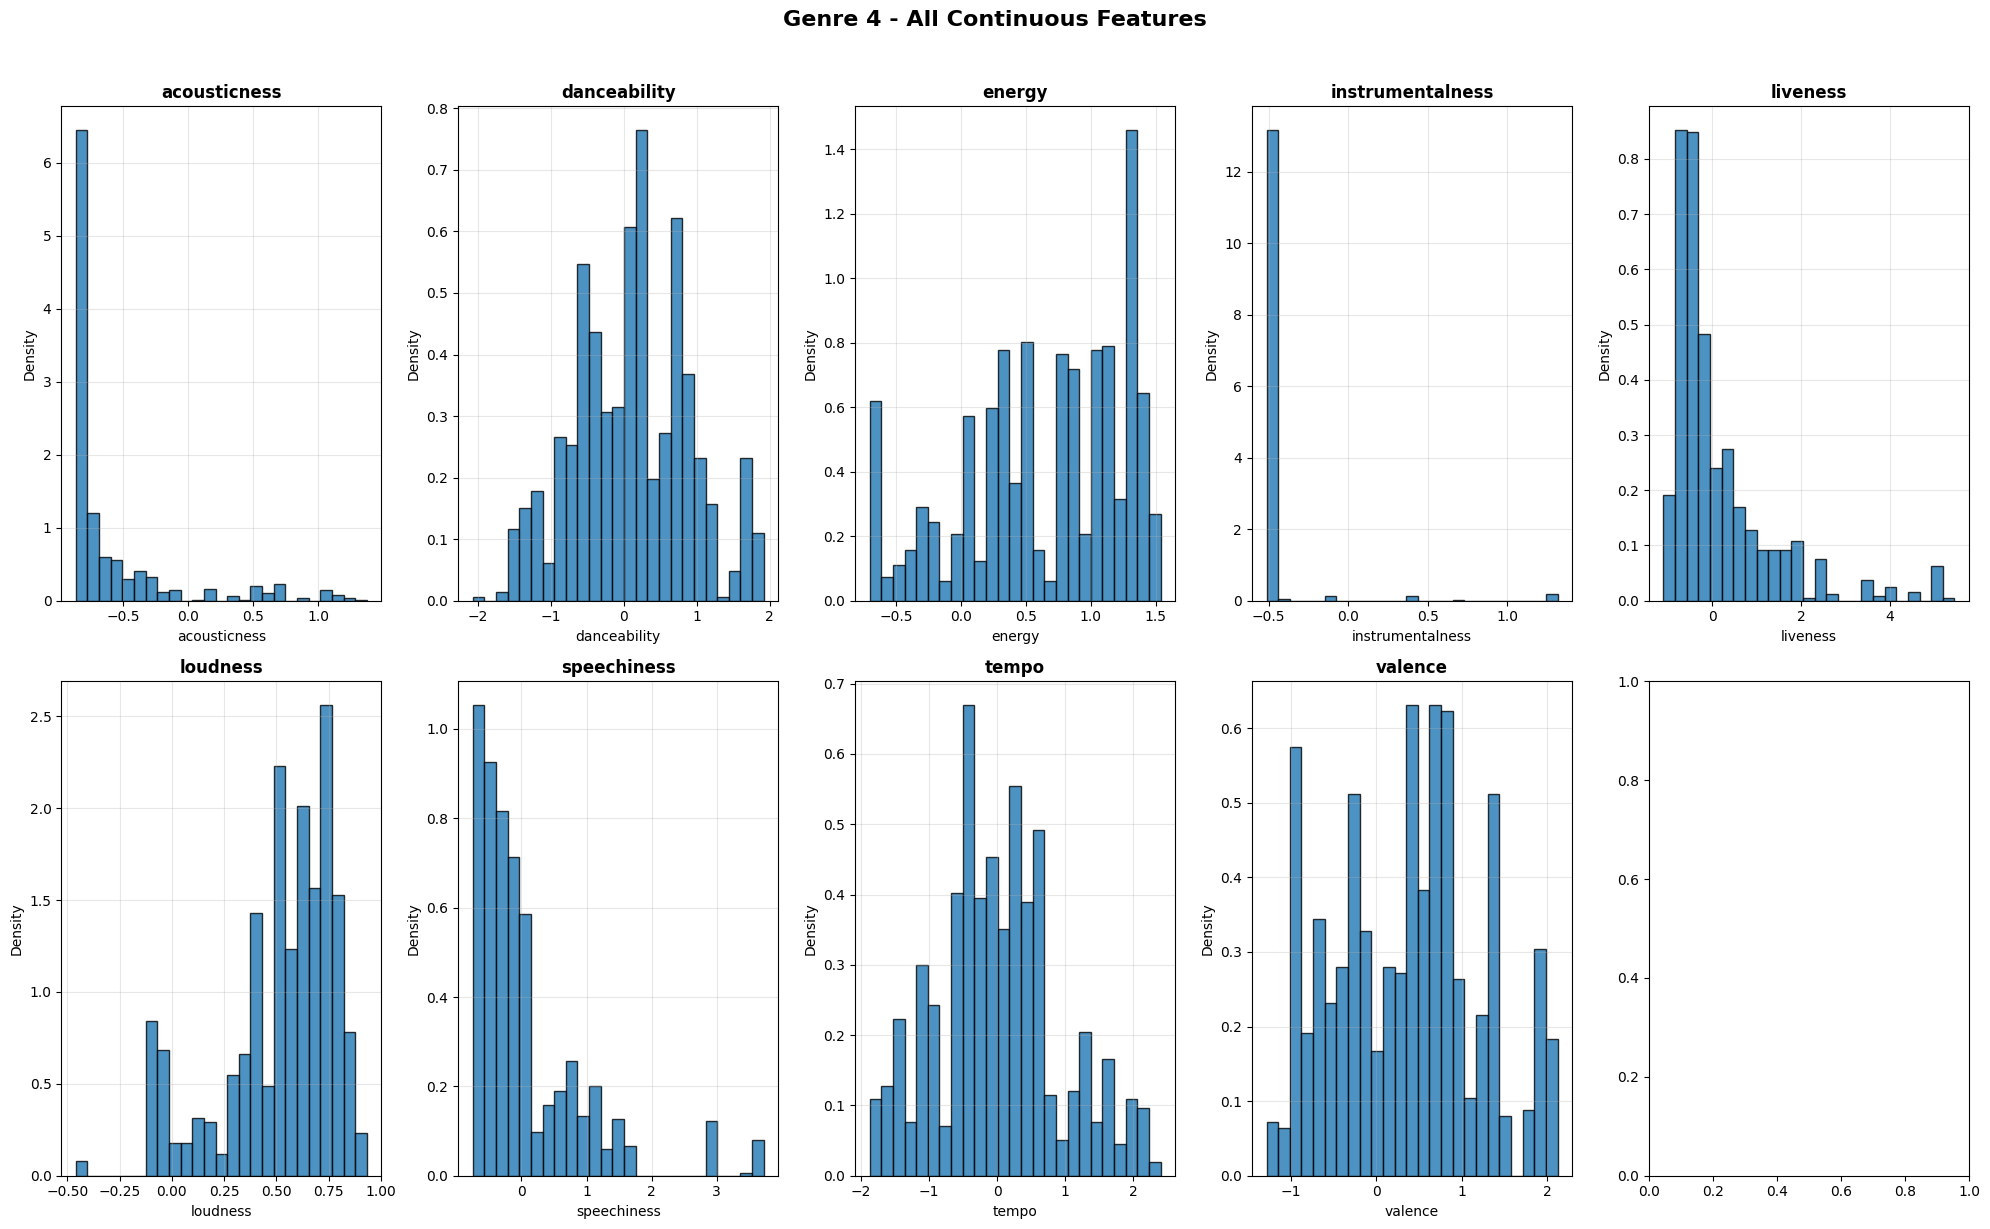

<Figure size 2000x1200 with 0 Axes>

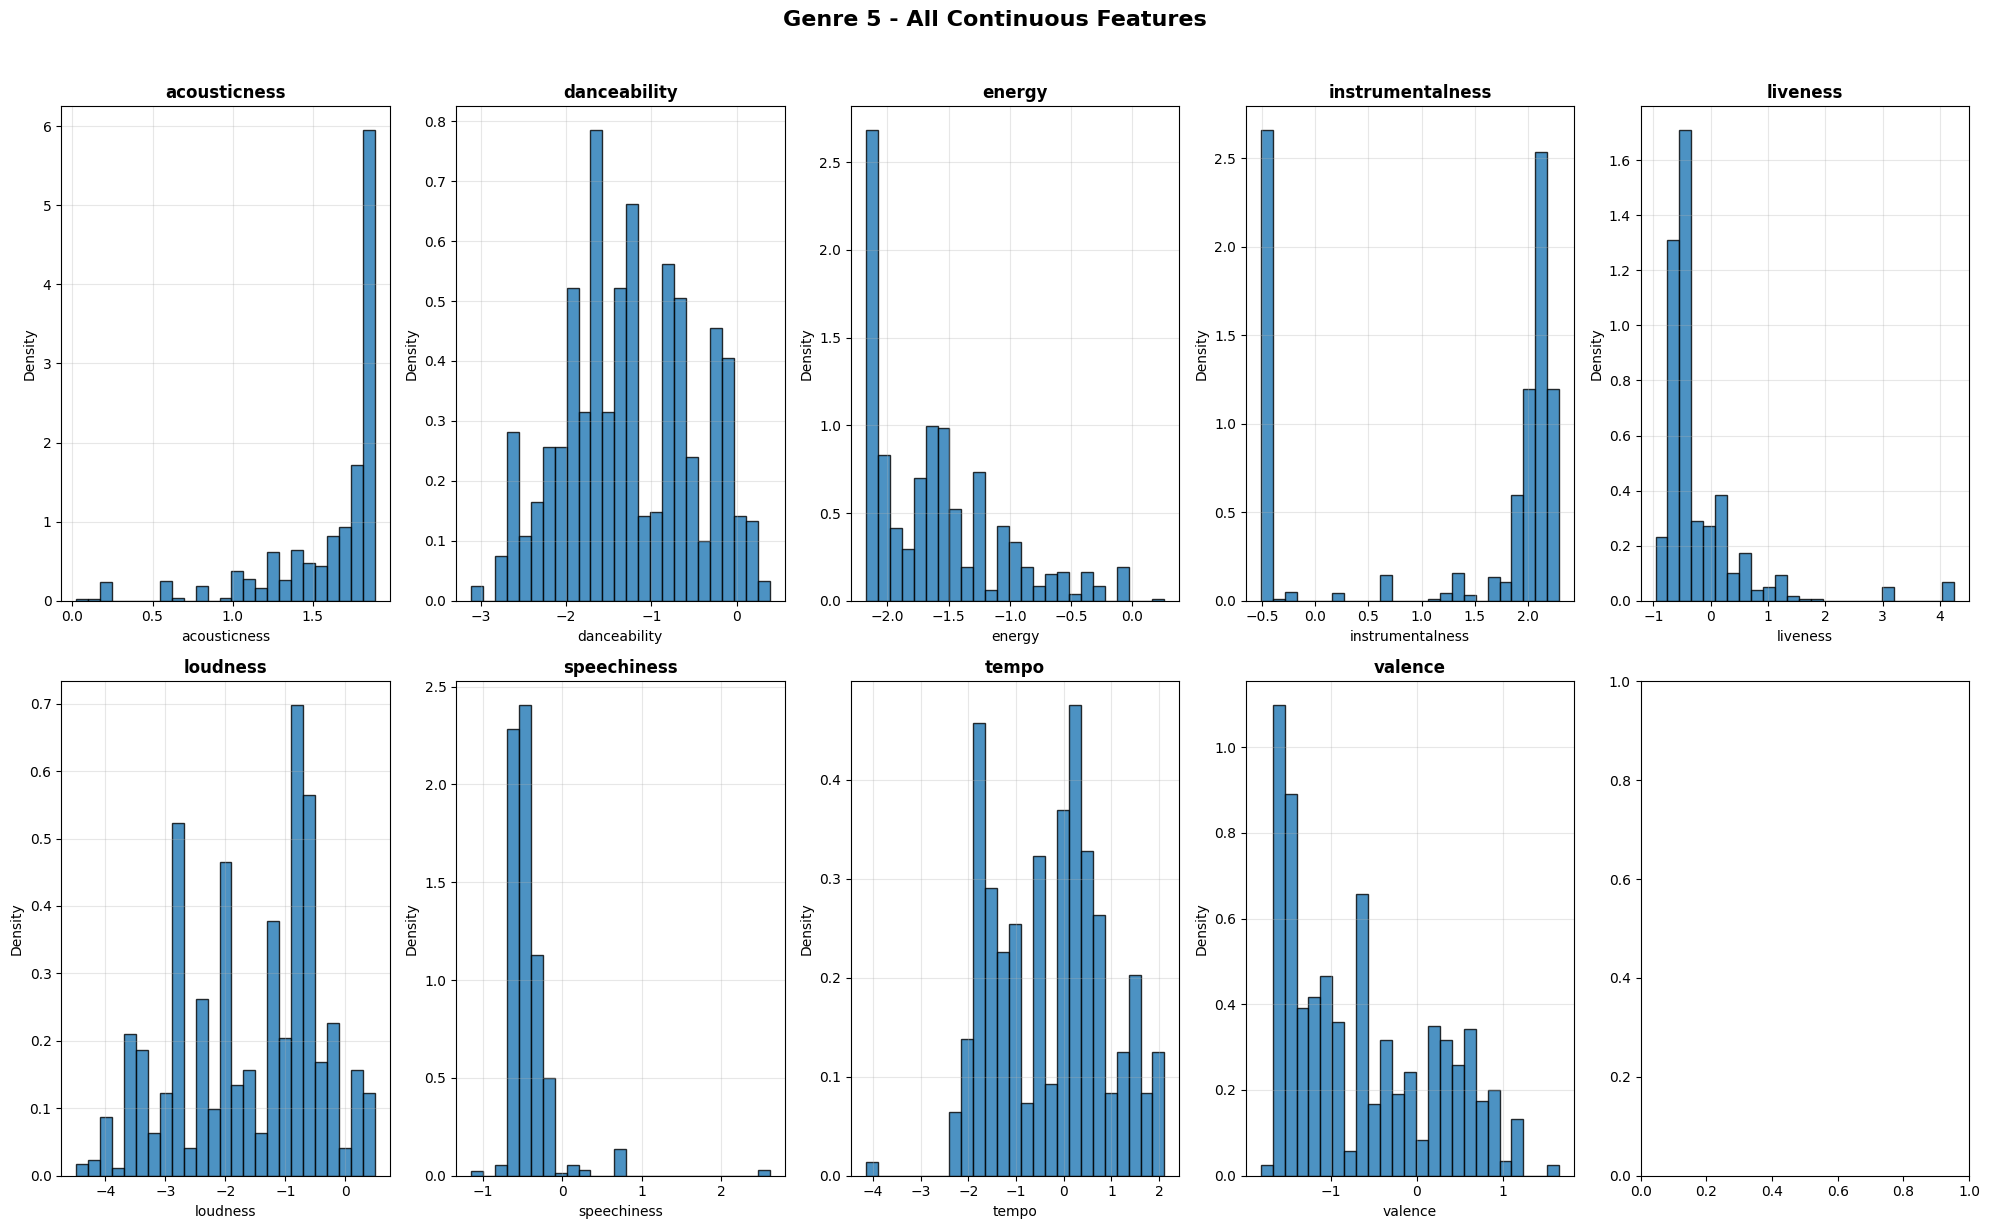

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

continuous_features = [
    'acousticness', 'danceability', 'energy', 'instrumentalness',
    'liveness', 'loudness', 'speechiness', 'tempo', 'valence'
]

# One figure PER GENRE
for genre in sorted(df['first_genre'].unique()):
    plt.figure(figsize=(20, 12))
    
    # 2x5 subplot grid for 10 features
    fig, axes = plt.subplots(2, 5, figsize=(20, 12))
    axes = axes.flatten()
    
    genre_data = df[df['first_genre'] == genre][continuous_features].dropna()
    
    for idx, feature in enumerate(continuous_features):
        axes[idx].hist(genre_data[feature], bins=25, edgecolor='black', alpha=0.8, density=True)
        axes[idx].set_title(f'{feature}', fontweight='bold')
        axes[idx].set_xlabel(feature)
        axes[idx].set_ylabel('Density')
        axes[idx].grid(True, alpha=0.3)
    
    plt.suptitle(f'Genre {genre} - All Continuous Features', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()


In [48]:
## Not all are looks normal, many of them are skewed.
# Use median imputation within each genre group for all audio features. 

In [49]:
for feature in features:
    if feature in imputation_values.columns:
        df[feature] = df[feature].fillna(df['first_genre'].map(imputation_values[feature]))

df.head()

,position,track_id,track_name,popularity,first_genre,user,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key,mode
0,0,7p6oXzBSPAXXz8Xb8gBPki,Subzero - Original Mix,-1.878208,3,19befa2d20a544b3819a1236cf7536c4_Harsh1,0.760508,1.090316,0.089171,1.973417,-0.532155,-0.321326,-0.102106,0.072394,-1.339579,6.0,0.0
1,0,3ENHpbTuY72FukZbwGP6bc,Tear Away,-0.462352,4,24bebb12512f476a8e08b14a1aaa08ea_Hannah,-0.859325,0.125299,0.238413,-0.505092,-0.642365,0.565785,-0.461710,0.342731,0.034194,0.0,1.0
2,0,6nz35DNIzbtj5ztpDEcW1j,"Kick, Push",-0.655423,2,6016a0c171f34d44bc5840e0f521a034_D,-0.614055,0.793388,0.182447,-0.513179,-0.304894,0.432448,0.080797,-0.131009,0.236815,NaN,NaN
3,0,7p6oXzBSPAXXz8Xb8gBPki,Subzero - Original Mix,-1.878208,3,6f0f1e2e101f4f208ede37b241d6fc4c_31owtsxu6xlbj...,0.760508,1.090316,0.089171,1.973417,-0.532155,-0.321326,-0.102106,0.072394,-1.339579,6.0,0.0
4,0,1lK5iIMKifrxERzS3iimJH,Breathe on Me,-1.170280,1,f9a2b3c8d4e1f7a0b5c6d9e2f1a3b8c,-0.855079,0.644924,-0.071264,-0.477078,-0.600561,0.337566,-0.415210,-0.359908,0.496171,5.0,0.0


In [50]:
# Build a dataframe with just the songs. 
# For cases where one track has different audio features (because they belong to different first_genre), collapse to the smallest first_genre's audio features.

tracks = df[['track_id','track_name', 'first_genre', 'position']+features].drop_duplicates()
tracks = tracks.sort_values(['track_id', 'first_genre'])
tracks = tracks.groupby('track_id').first().reset_index()
tracks = tracks.drop(columns=['position', 'first_genre'])
print(tracks.shape)
tracks.head()

(682, 12)


,track_id,track_name,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,02VBYrHfVwfEWXk5DXyf0T,Leave The Door Open,0.631718,-0.358996,-0.007258,0.119020,-0.513179,-0.580800,0.140389,-0.643063,0.853481,1.095930
1,04aAxqtGp5pv12UXAg4pkq,Centuries,0.503004,-0.850943,-1.030601,1.021935,-0.513179,-0.510113,0.780807,-0.015304,1.798697,0.451594
2,08B8Ki7qlUoT58Zd1trxkl,"Requiem In D Minor, K. 626: Sequence: VI. Lacr...",-0.526709,1.777988,-2.725744,-1.824486,1.346714,3.031821,-1.920863,-0.497361,1.949065,-1.521533
3,08mG3Y1vljYA6bvDt4Wqkj,Back In Black,0.760433,-0.830511,-1.470691,0.432428,-0.485309,-0.656047,0.427672,-0.416760,2.216088,1.274237
4,09CnYHiZ5jGT1wr1TXJ9Zt,Thank You (Not So Bad),0.503004,-0.797698,0.454041,1.365191,-0.275494,1.739699,0.494152,-0.388859,0.918774,0.463751


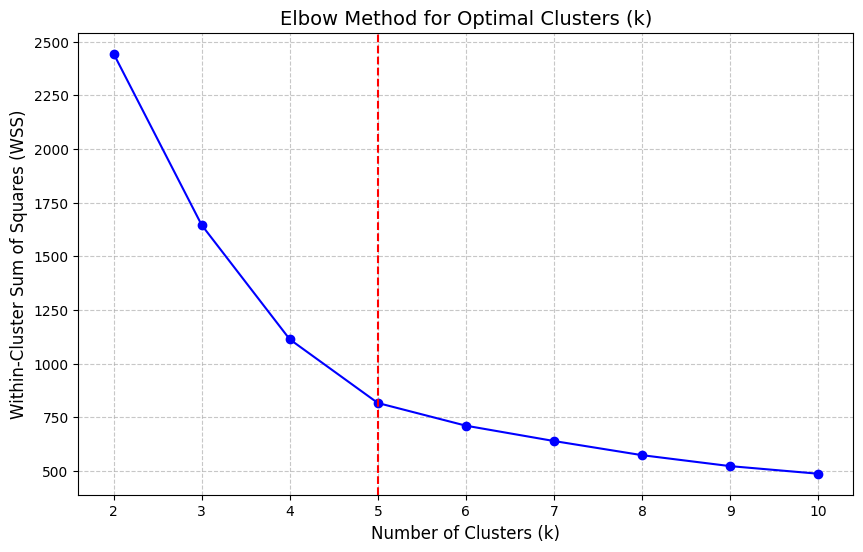

In [51]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

# Apply PCA before clustering
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca_results = pca.fit_transform(tracks[features])
tracks['PCA1'] = pca_results[:, 0]
tracks['PCA2'] = pca_results[:, 1]
tracks['PCA3'] = pca_results[:, 2]

input = tracks[['PCA1','PCA2','PCA3']]
# input = tracks[features]

wss = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters = k, random_state = 42, n_init=10)
    kmeans.fit(input)
    wss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, wss, marker='o', color='b', linestyle='-')
plt.title('Elbow Method for Optimal Clusters (k)', fontsize=14)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Within-Cluster Sum of Squares (WSS)', fontsize=12)
plt.axvline(x=5, color='r', linestyle='--')
plt.xticks(k_range)
plt.grid(True, linestyle='--', alpha=0.7)

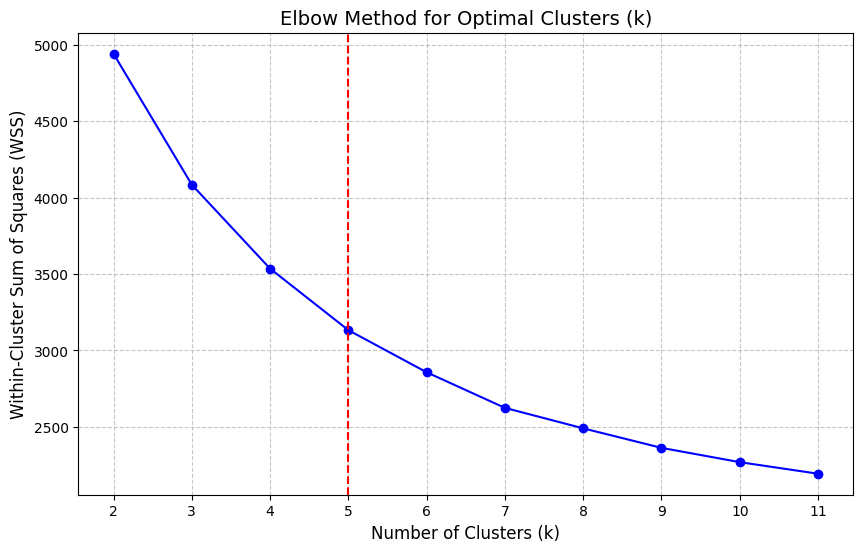

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt


input = tracks[features]

wss = []
k_range = range(2, 12)

for k in k_range:
    kmeans = KMeans(n_clusters = k, random_state = 42, n_init=10)
    kmeans.fit(input)
    wss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, wss, marker='o', color='b', linestyle='-')
plt.title('Elbow Method for Optimal Clusters (k)', fontsize=14)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Within-Cluster Sum of Squares (WSS)', fontsize=12)
plt.axvline(x=5, color='r', linestyle='--')
plt.xticks(k_range)
plt.grid(True, linestyle='--', alpha=0.7)

In [52]:
# Assign clusters using k = 5

optimal_k = 5
kmeans = KMeans(n_clusters = optimal_k, random_state = 42, n_init=10)
cluster_labels = kmeans.fit_predict(input)
tracks['cluster'] = cluster_labels

tracks.groupby('cluster')['track_id'].count().reset_index()

,cluster,track_id
0,0,66
1,1,115
2,2,95
3,3,61
4,4,345


In [53]:
df = pd.merge(df, tracks[['track_id', 'cluster']], how = 'inner', on='track_id')
df.groupby('cluster').agg({'track_id':pd.Series.nunique})

,track_id
cluster,
0,66
1,115
2,95
3,61
4,345


In [54]:
sample = df[df['user'] == '19befa2d20a544b3819a1236cf7536c4_Harsh1'][['position','cluster']].sort_values(by='position', ascending=True).reset_index(drop=True)
sample['next_cluster'] = sample['cluster'].shift(-1)
sample = sample.dropna(subset=['next_cluster'])

counts = pd.crosstab(sample['cluster'], 
                     sample['next_cluster'], 
                     normalize='index')

all_clusters = [0, 1, 2, 3, 4]
transition_matrix = counts.reindex(index=all_clusters, columns=all_clusters, fill_value=0)
print(transition_matrix)

next_cluster         0    1    2         3         4
cluster                                             
0             0.000000  0.0  0.0  0.333333  0.666667
1             0.000000  0.0  0.0  0.000000  0.000000
2             0.000000  0.0  0.0  0.000000  0.000000
3             0.071429  0.0  0.0  0.285714  0.642857
4             0.058824  0.0  0.0  0.235294  0.705882


In [39]:
df = df.sort_values(['user', 'position'])
df['next_cluster'] = df.groupby('user')['cluster'].shift(-1)
df.dropna(subset=['next_cluster'], inplace=True)

def get_transition_matrix(group):
    # Create crosstab
    matrix = pd.crosstab(group['cluster'], group['next_cluster'], normalize='index')
    all_clusters = [0, 1, 2, 3, 4]
    return matrix.reindex(index=all_clusters, columns=all_clusters, fill_value=0)

genre_matrices = df.groupby('first_genre').apply(get_transition_matrix)
genre_matrices

C:\Users\rahul\AppData\Local\Temp\ipykernel_16252\3312929355.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  genre_matrices = df.groupby('first_genre').apply(get_transition_matrix)


next_cluster                0         1         2         3         4
first_genre cluster                                                  
1           0        0.066667  0.266667  0.000000  0.666667  0.000000
            1        0.020942  0.219895  0.000000  0.759162  0.000000
            2        0.000000  0.000000  0.000000  1.000000  0.000000
            3        0.015314  0.228178  0.001531  0.754977  0.000000
            4        0.000000  0.000000  0.000000  0.000000  0.000000
2           0        0.289062  0.011719  0.007812  0.691406  0.000000
            1        0.066667  0.066667  0.000000  0.866667  0.000000
            2        0.000000  0.000000  0.000000  1.000000  0.000000
            3        0.294118  0.019078  0.003180  0.683625  0.000000
            4        0.000000  0.000000  0.000000  0.000000  0.000000
3           0        0.057692  0.000000  0.230769  0.711538  0.000000
            1        0.000000  0.000000  0.000000  0.000000  0.000000
            2        0.060185  0.000000  0.250000  0.689815  0.000000
            3        0.056962  0.000000  0.215190  0.727848  0.000000
            4        0.000000  0.000000  0.000000  0.000000  0.000000
4           0        0.129412  0.058824  0.000000  0.811765  0.000000
            1        0.000000  0.000000  0.000000  1.000000  0.000000
            2        0.000000  0.000000  0.000000  0.000000  0.000000
            3        0.097257  0.022444  0.000000  0.880299  0.000000
            4        0.000000  0.000000  0.000000  0.000000  0.000000
5           0        0.000000  0.000000  0.000000  0.000000  0.000000
            1        0.000000  0.360465  0.058140  0.000000  0.581395
            2        0.000000  0.300000  0.000000  0.000000  0.700000
            3        0.000000  0.000000  0.000000  0.000000  0.000000
            4        0.000000  0.366972  0.000000  0.000000  0.633028

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_genre_matrix(genre_name):
    plt.figure(figsize=(6, 4))
    sns.heatmap(genre_matrices.loc[genre_name], annot=True, cmap='Blues', fmt='.2f')
    plt.title(f'Transition Matrix for {genre_name}')
    plt.ylabel('Current Cluster')
    plt.xlabel('Next Cluster')
    plt.show()

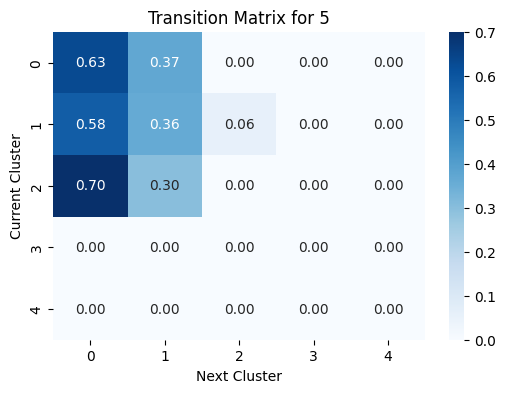

In [11]:
plot_genre_matrix(5)

In [ ]:
cluster_profile = tracks.groupby('cluster')[features].mean()
cluster_profile

,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
cluster,,,,,,,,,,
0,-1.104066,1.806808,-1.476157,-1.877820,2.029159,-0.445039,-2.214402,-0.412095,-0.602386,-1.075037
1,-0.097249,0.997541,-0.557014,-0.871923,-0.229395,-0.031005,-0.269333,-0.473827,-0.250256,-0.284284
2,-3.015843,-0.373956,0.734655,0.325691,1.601595,-0.114683,-0.190811,-0.038459,0.199811,-0.599126
3,0.247610,-0.542234,0.320905,0.575977,-0.450094,0.037690,0.468820,-0.199258,0.155547,0.323174
4,0.124247,-0.207183,0.777220,0.274134,-0.477237,0.508034,0.314175,2.802456,0.114461,0.638471


SOng style / genre based on clusters:   

Cluster 0: Atmospheric / Classical (+1.81 Acoustic, +2.03 Instrumental, -1.88 Energy, -2.21 Loudness).  
Cluster 1: Chill Acoustic (+1.00 Acoustic, -0.87 Energy, -0.56 Danceability).  
Cluster 2: Niche / Underground (-3.02 Popularity, +1.60 Instrumental, +0.73 Danceability).  
Cluster 3: Mainstream high energy (+0.24 Popularity, +0.58 Energy).  
Cluster 4: Urban / hip-hop (+2.8 Speechiness, +0.78 Danceability, +0.64 Valence).  

Labels generated using Google Gemini